# Whittle-Matern
## spatially varying anisotropic covariance

### Neumann boundary conditions

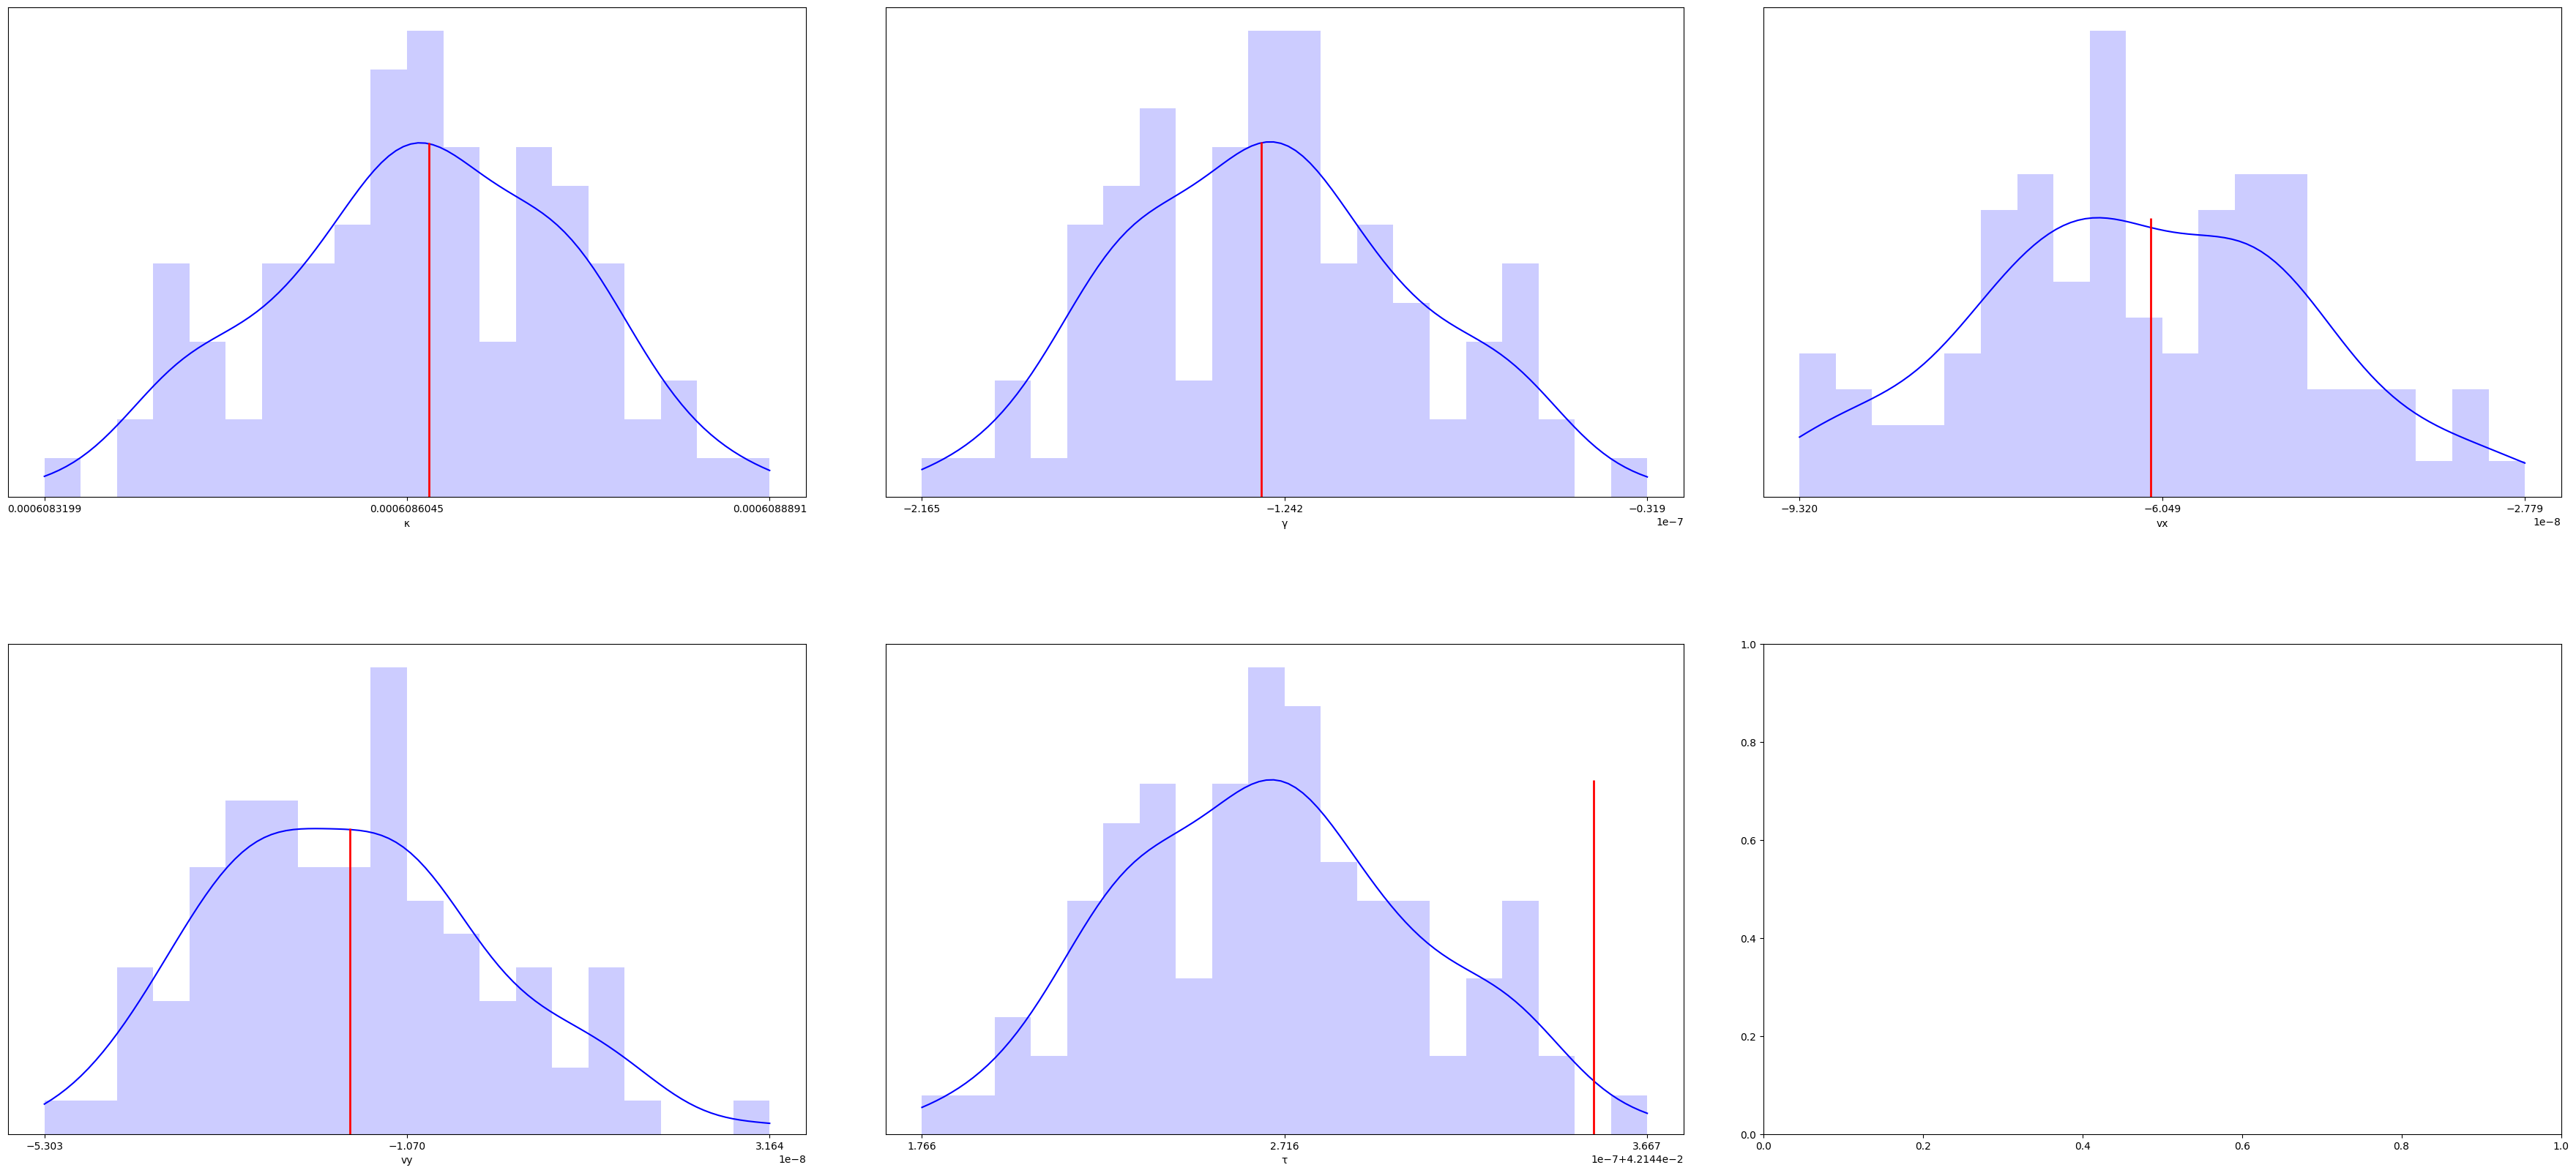

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/whittle-matern-anisotropic-2D-bc1.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 3
n = 2
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.array(["\u03BA", "\u03B3", "vx","vy", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

### Dirichlet boundary conditions

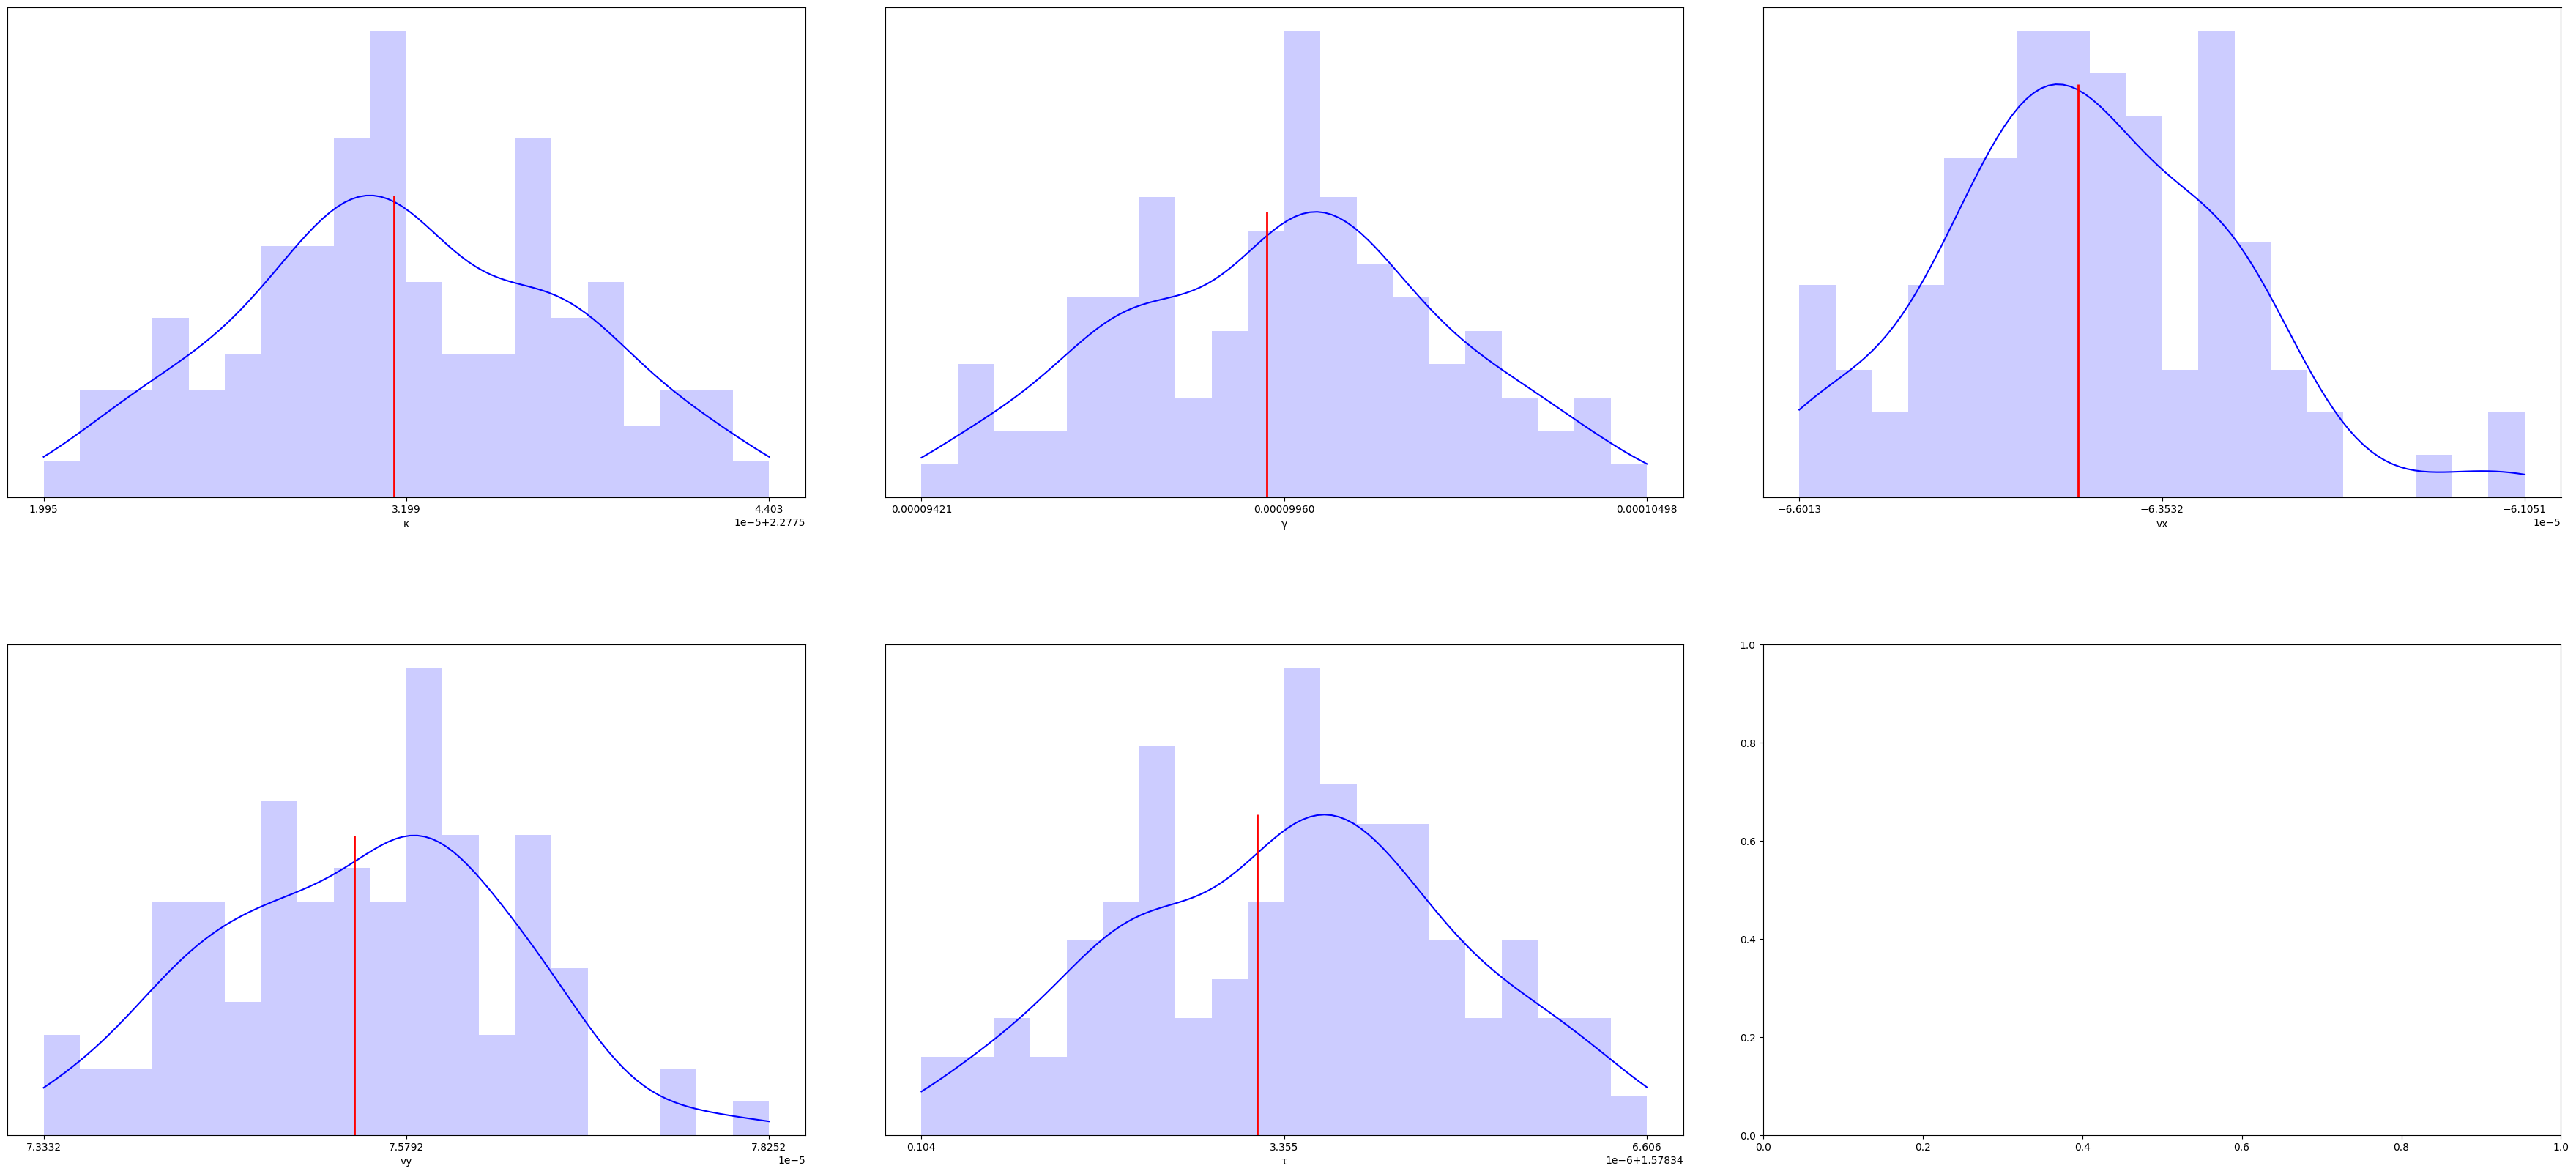

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/whittle-matern-anisotropic-2D-bc3.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 3
n = 2
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.array(["\u03BA", "\u03B3", "vx","vy", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

### Wrapping boundary conditions

IndexError: index 5 is out of bounds for axis 0 with size 5

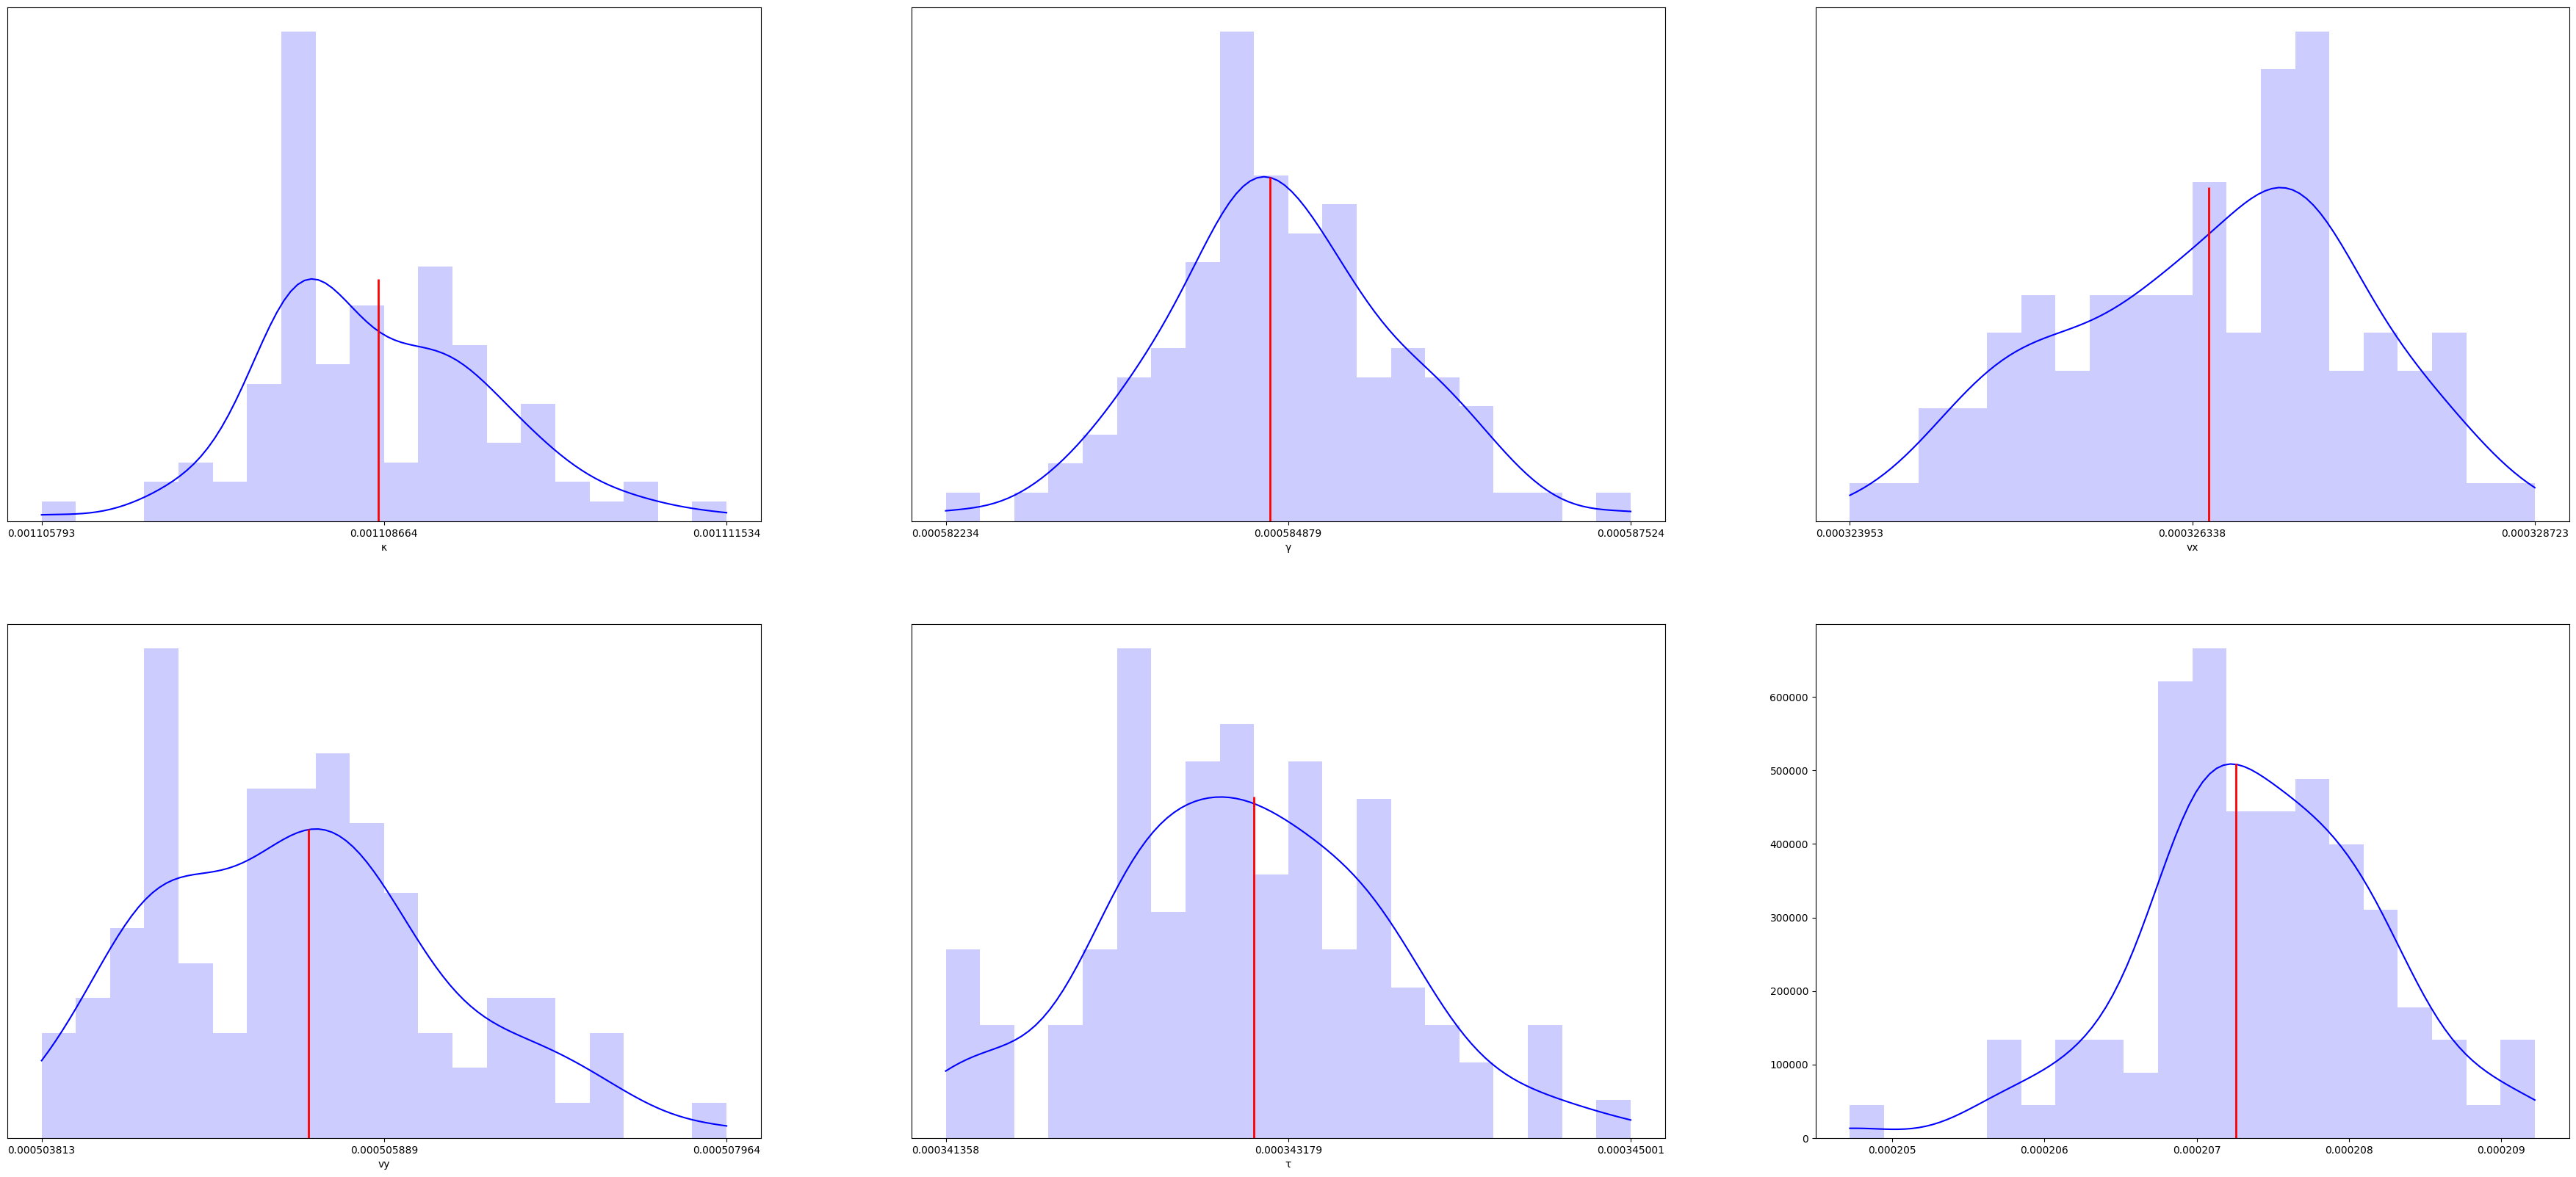

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/whittle-matern-anisotropic-2D-bc2.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 3
n = 2
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.array(["\u03BA", "\u03B3", "vx","vy", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

#### Visualization

In [ ]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', ha = True, bc = bc, anisotropic = True,
        parameters = np.load('../fits/whittle_matern_ani_bc3.npy'))
mod.mod.setPars(mod.mod.initFit(data['muf']))
mod.mod.setQ()

#### Prediction on test set

# Diffusion

In [2]:
par = np.hstack([mod.mod.gamma, mod.mod.vx,mod.mod.vy],dtype=np.float64)

h = 0.000001
n = 100

res = []
for i in tqdm(range(n)):
    ngrad = []
    for i in range(par.shape[0]):
        par1 = par.copy()
        par2 = par.copy()
        par1[i] = par1[i] + h
        par2[i] = par2[i] - h
        gamma1 = np.exp(mod.grid.evalBH(par1[:9]))
        gamma2 = np.exp(mod.grid.evalBH(par2[:9]))
        vv1 = np.stack([mod.grid.evalBH(par1[9:18]),mod.grid.evalBH(par1[18:])],axis=2) 
        vv2 = np.stack([mod.grid.evalBH(par2[9:18]),mod.grid.evalBH(par2[18:])],axis=2) 
        Hs1 = (np.eye(2)*(np.stack([gamma1,gamma1],axis=2))[:,:,:,np.newaxis]) + vv1[:,:,:,np.newaxis]*vv1[:,:,np.newaxis,:]
        Hs2 = (np.eye(2)*(np.stack([gamma2,gamma2],axis=2))[:,:,:,np.newaxis]) + vv2[:,:,:,np.newaxis]*vv2[:,:,np.newaxis,:]
        res1 = mod.mod.Ah(Hs1)
        res2 = mod.mod.Ah(Hs2)
        ngrad.append((res1 - res2)/(2*h))
        
    sgrad = []
    gamma = np.exp(mod.grid.evalBH(par[:9]))
    vv = np.stack([mod.grid.evalBH(par[9:18]),mod.grid.evalBH(par[18:])],axis=2) 
    for i in range(9):
        dHs = np.eye(2)*(np.stack([mod.grid.bsH[:,:,i]*gamma,mod.grid.bsH[:,:,i]*gamma],axis=2)[:,:,:,np.newaxis])
        sgrad.append(mod.mod.Ah(dHs))
    for i in range(9):
        dpar = np.zeros(9)
        dpar[i] = 1
        dv = np.stack([mod.grid.evalBH(dpar),mod.grid.evalBH(np.zeros(9))],axis = 2)
        dHs = vv[:,:,:,np.newaxis]*dv[:,:,np.newaxis,:]  + dv[:,:,:,np.newaxis]*vv[:,:,np.newaxis,:]
        sgrad.append(mod.mod.Ah(dHs))
    for i in range(9):
        dpar = np.zeros(9)
        dpar[i] = 1
        dv = np.stack([mod.grid.evalBH(par = np.zeros(9)),mod.grid.evalBH(par = dpar)],axis = 2)
        dHs = vv[:,:,:,np.newaxis]*dv[:,:,np.newaxis,:]  + dv[:,:,:,np.newaxis]*vv[:,:,np.newaxis,:] 
        sgrad.append(mod.mod.Ah(dHs))
        

    res.append([np.allclose(ngrad[i].A, sgrad[i].A) for i in range(par.shape[0])])

print(np.all(res))

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [06:03<00:00,  3.64s/it]

True


# log-likelihood

In [3]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', ha = False, bc = bc, anisotropic = True)
mod.mod.setPars(mod.mod.initFit(data['muf']))
mod.mod.setQ()

par = mod.mod.getPars()
h = 0.001
n = 100

ngrad = []
for i in tqdm(range(par.shape[0])):
    par1 = par.copy()
    par2 = par.copy()
    par1[i] = par1[i] + h
    par2[i] = par2[i] - h
    res1 = mod.mod.logLike(par1,grad = False)
    res2 = mod.mod.logLike(par2,grad = False)
    ngrad.append((res1 - res2)/(2*h))
    
sgrad = []
for i in tqdm(range(100)):
    sgrad.append(mod.mod.logLike(par))
    


100%|██████████| 100/100 [01:24<00:00,  1.18it/s]


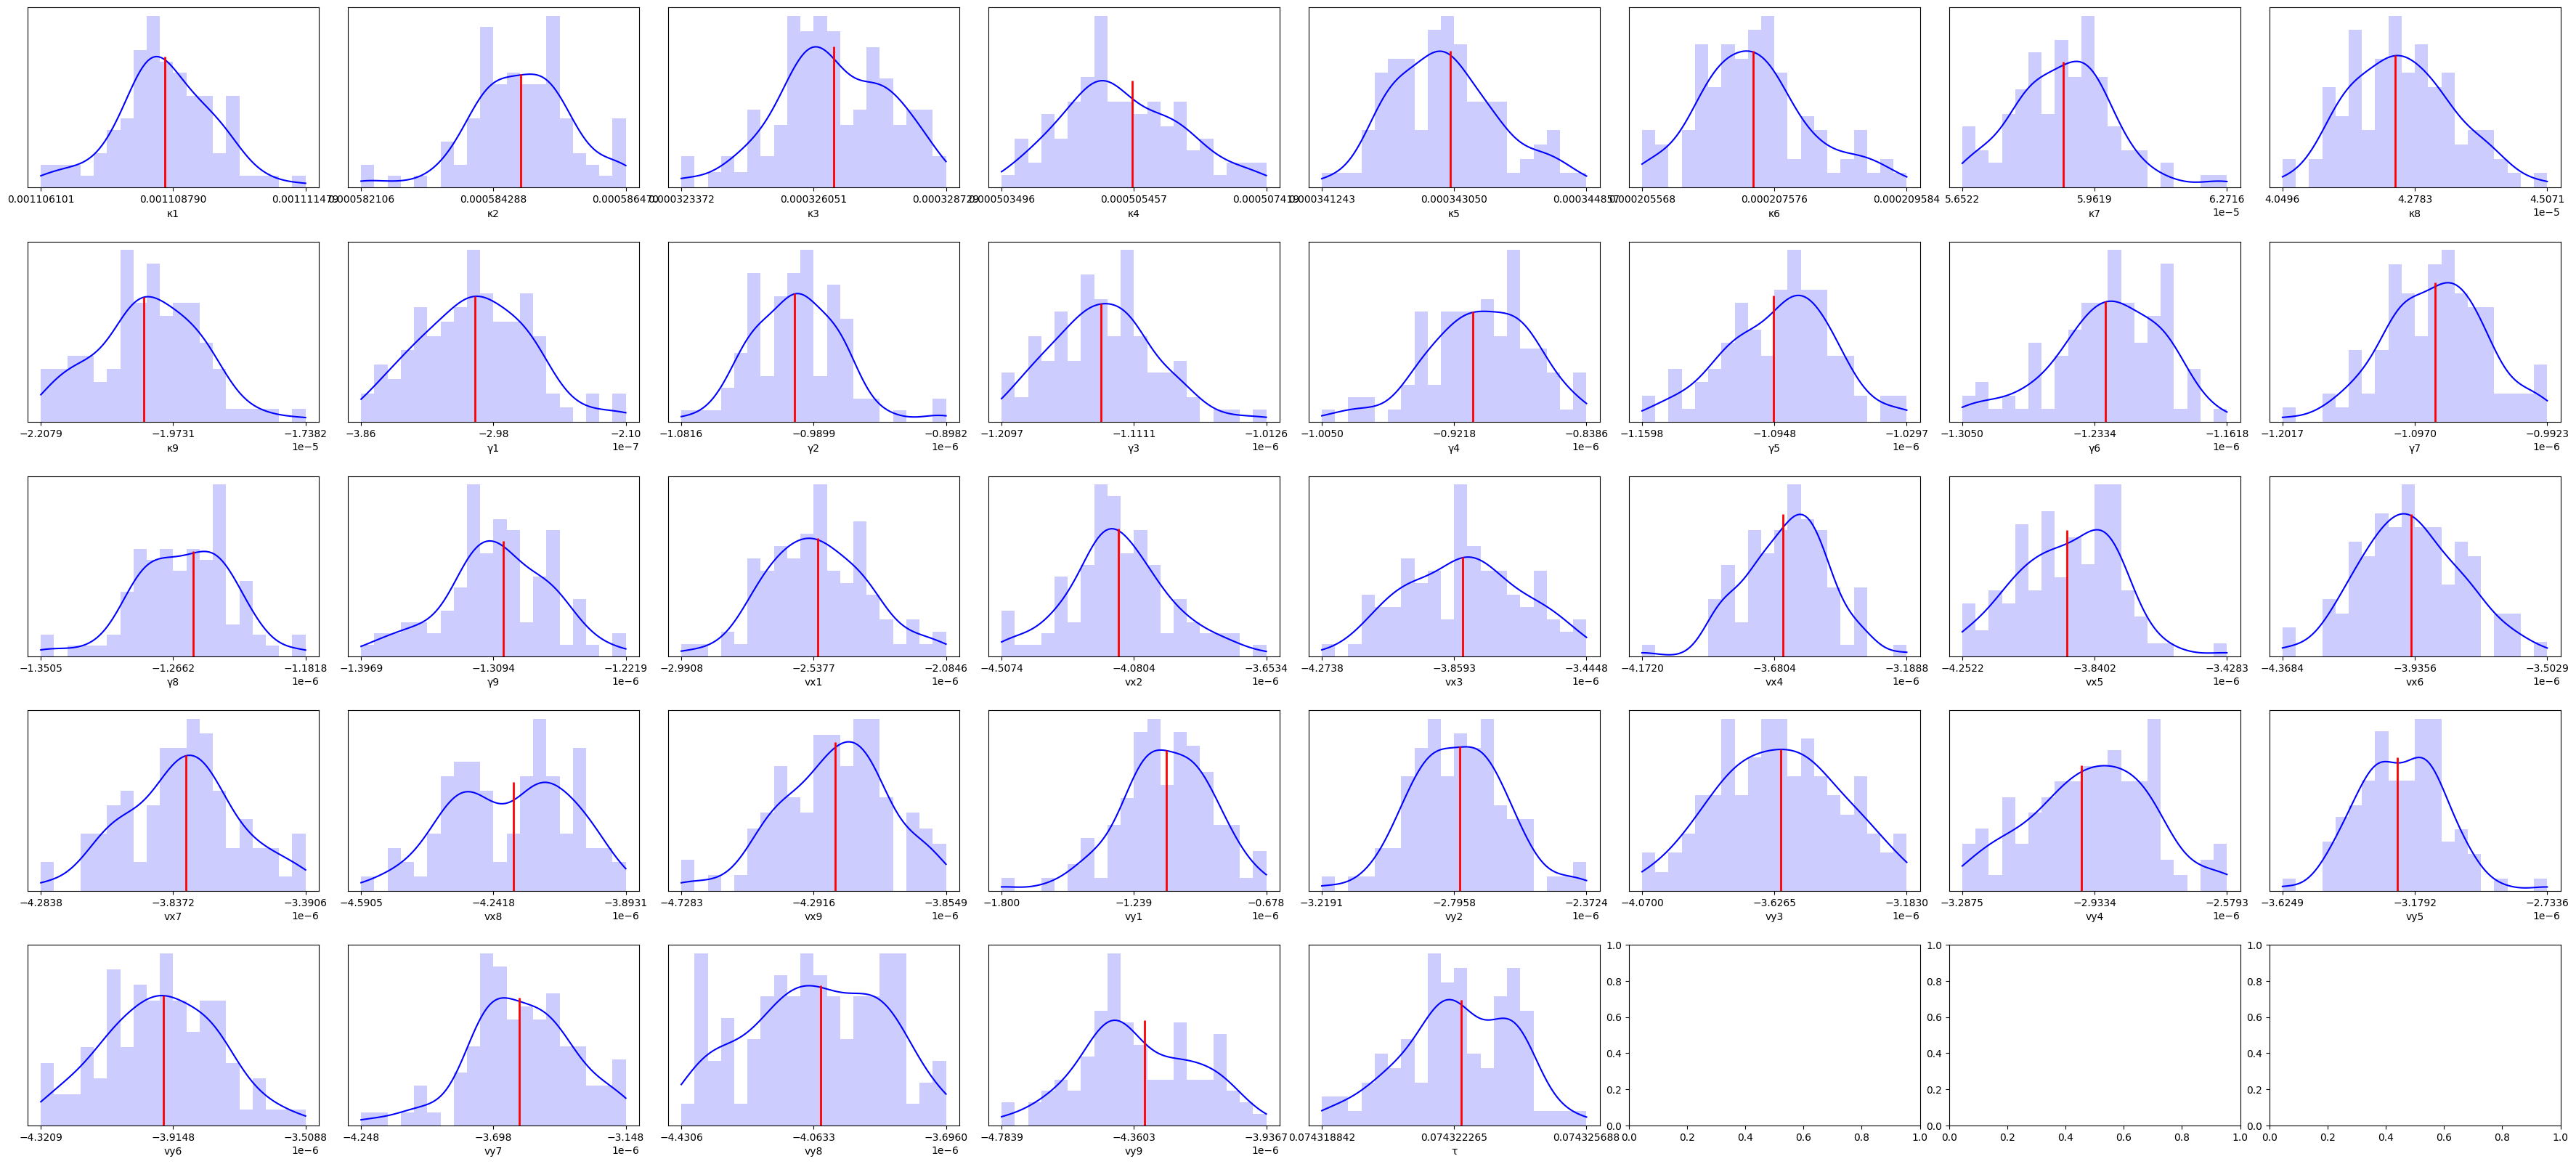

In [4]:
m = 8
n = 5
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    ["vx%d"%i for i in range(1,10)],
                    ["vy%d"%i for i in range(1,10)], "\u03C4"])
sgrad2 = np.stack([sgrad[i][1] for i in range(len(sgrad))],axis = 1)
for i in range(m):
    for j in range(n):
        if i + j*m >= par.size:
            break
        tx = np.linspace(sgrad2[i + j*m,:].min(),sgrad2[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad2[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad2[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)